<a href="https://colab.research.google.com/github/RANGAM-AKHILA/TESS/blob/main/text_only_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall sympy -y
!pip install sympy==1.13.1



Found existing installation: sympy 1.11.1
Uninstalling sympy-1.11.1:
  Successfully uninstalled sympy-1.11.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 71.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.9.0+cu128 requires sympy>=1.13.3, but you have sympy 1.13.1 which is incompatible.


In [ ]:
import torch
import sympy

print("Torch:", torch.__version__)
print("SymPy:", sympy.__version__)



Torch: 2.9.0+cu128
SymPy: 1.13.1


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
from tqdm import tqdm


In [ ]:
class TextFeatureDataset(Dataset):
    def __init__(self, root_dir):
        self.samples = []

        for file in os.listdir(root_dir):
            if file.endswith(".pt"):
                emotion = file.replace(".pt", "").split("_")[-1]
                self.samples.append(
                    (os.path.join(root_dir, file), emotion)
                )

        print("Total samples:", len(self.samples))
        print("Class distribution:", Counter([e for _, e in self.samples]))

        self.label_encoder = LabelEncoder()
        self.label_encoder.fit([e for _, e in self.samples])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, emotion = self.samples[idx]

        features = torch.load(path).float()   # (T, 768)
        label = self.label_encoder.transform([emotion])[0]

        return features, torch.tensor(label), features.shape[0]


In [ ]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):

    features, labels, lengths = zip(*batch)

    lengths = torch.tensor(lengths)

    padded_features = pad_sequence(
        features,
        batch_first=True
    ).float()

    labels = torch.stack(labels)

    return padded_features, lengths, labels


In [ ]:
from torch.nn.utils.rnn import pack_padded_sequence
import torch.nn as nn
import torch

class TextEmotionModel(nn.Module):
    def __init__(self, num_classes):
        super(TextEmotionModel, self).__init__()

        # Temporal Modelling Block (CNN)
        self.cnn = nn.Sequential(
            nn.Conv1d(768, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )

        # Contextual Modelling Block (BiLSTM)
        self.lstm = nn.LSTM(
            input_size=256,
            hidden_size=128,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )

        # Fusion + Classification
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x, lengths, return_features=False):


        x = x.transpose(1, 2)          # (B, 768, T)
        temporal_out = self.cnn(x)     # (B, 256, T')
        temporal_out = temporal_out.transpose(1, 2)  # (B, T', 256)

        lengths = lengths // 2

        packed = pack_padded_sequence(
            temporal_out,
            lengths.cpu(),
            batch_first=True,
            enforce_sorted=False
        )

        _, (h, _) = self.lstm(packed)

        contextual_vec = torch.cat((h[-2], h[-1]), dim=1)  # (B, 256)

        fusion_vec = contextual_vec  # Here fusion = BiLSTM output

        logits = self.classifier(fusion_vec)

        if return_features:
            return logits, temporal_out, contextual_vec, fusion_vec

        return logits


In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/text_features"

dataset = TextFeatureDataset(DATA_DIR)

# 70 / 15 / 15 split
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset,
    [train_size, val_size, test_size]
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

num_classes = len(dataset.label_encoder.classes_)

model = TextEmotionModel(num_classes).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)

EPOCHS = 5


Total samples: 2723
Class distribution: Counter({'ps': 400, 'fear': 400, 'sad': 400, 'angry': 400, 'disgust': 400, 'happy': 400, 'neutral': 323})


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)


In [ ]:
for epoch in range(EPOCHS):

    # TRAIN
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for features, lengths, labels in tqdm(train_loader):

        features = features.to(DEVICE)
        lengths = lengths.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()

        outputs = model(features, lengths)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total

    # VALIDATION
    model.eval()
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for features, lengths, labels in val_loader:

            features = features.to(DEVICE)
            lengths = lengths.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(features, lengths)
            preds = torch.argmax(outputs, dim=1)

            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total

    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss/len(train_loader):.4f}")
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Validation Accuracy: {val_acc:.4f}")


100%|██████████| 120/120 [00:08<00:00, 14.27it/s]



Epoch 1/5
Train Loss: 1.9477
Train Accuracy: 0.1427
Validation Accuracy: 0.1127


100%|██████████| 120/120 [00:06<00:00, 17.63it/s]



Epoch 2/5
Train Loss: 1.9452
Train Accuracy: 0.1548
Validation Accuracy: 0.0882


100%|██████████| 120/120 [00:07<00:00, 16.96it/s]



Epoch 3/5
Train Loss: 1.9439
Train Accuracy: 0.1522
Validation Accuracy: 0.0882


100%|██████████| 120/120 [00:06<00:00, 18.34it/s]



Epoch 4/5
Train Loss: 1.9431
Train Accuracy: 0.1453
Validation Accuracy: 0.0760


100%|██████████| 120/120 [00:07<00:00, 17.14it/s]



Epoch 5/5
Train Loss: 1.9417
Train Accuracy: 0.1621
Validation Accuracy: 0.0613


In [ ]:
model.eval()

all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for features, lengths, labels in test_loader:

        features = features.to(DEVICE)
        lengths = lengths.to(DEVICE)

        outputs = model(features, lengths)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probs.cpu().numpy())

print("\n===== TEST RESULTS =====")
print(classification_report(all_labels, all_preds))

cm = confusion_matrix(all_labels, all_preds)
print("\nConfusion Matrix:\n", cm)



===== TEST RESULTS =====
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        59
           1       0.02      0.02      0.02        53
           2       0.09      0.17      0.12        71
           3       0.03      0.02      0.02        52
           4       0.00      0.00      0.00        44
           5       0.10      0.30      0.15        63
           6       0.00      0.00      0.00        67

    accuracy                           0.08       409
   macro avg       0.03      0.07      0.04       409
weighted avg       0.04      0.08      0.05       409


Confusion Matrix:
 [[ 0  6 17  5  0 31  0]
 [ 0  1 24  7  0 21  0]
 [ 0  6 12  8  0 45  0]
 [ 0  5 15  1  0 31  0]
 [ 0 10 10  3  0 21  0]
 [ 0  9 29  6  0 19  0]
 [ 0  5 24 10  0 28  0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
print("\n===== SAMPLE INFERENCE =====\n")

label_encoder = dataset.label_encoder

for i in range(10):

    true_label = label_encoder.inverse_transform([all_labels[i]])[0]
    pred_label = label_encoder.inverse_transform([all_preds[i]])[0]
    confidence = np.max(all_probs[i])

    print(f"Sample {i+1}")
    print(f"True Emotion     : {true_label}")
    print(f"Predicted Emotion: {pred_label}")
    print(f"Confidence       : {confidence:.4f}")
    print("-" * 40)



===== SAMPLE INFERENCE =====

Sample 1
True Emotion     : fear
Predicted Emotion: happy
Confidence       : 0.1608
----------------------------------------
Sample 2
True Emotion     : sad
Predicted Emotion: happy
Confidence       : 0.1588
----------------------------------------
Sample 3
True Emotion     : angry
Predicted Emotion: happy
Confidence       : 0.1611
----------------------------------------
Sample 4
True Emotion     : disgust
Predicted Emotion: happy
Confidence       : 0.1619
----------------------------------------
Sample 5
True Emotion     : fear
Predicted Emotion: happy
Confidence       : 0.1609
----------------------------------------
Sample 6
True Emotion     : neutral
Predicted Emotion: happy
Confidence       : 0.1601
----------------------------------------
Sample 7
True Emotion     : ps
Predicted Emotion: happy
Confidence       : 0.1602
----------------------------------------
Sample 8
True Emotion     : fear
Predicted Emotion: happy
Confidence       : 0.1599
------

In [ ]:
import numpy as np

model.eval()

temporal_feats = []
contextual_feats = []
fusion_feats = []
labels_all = []

with torch.no_grad():
    for features, lengths, labels in test_loader:

        features = features.to(DEVICE)
        lengths = lengths.to(DEVICE)

        logits, temp, ctx, fus = model(
            features,
            lengths,
            return_features=True
        )

        # Temporal → mean over time dimension
        temp = temp.mean(dim=1).cpu().numpy()

        # Contextual & Fusion already fixed size
        ctx = ctx.cpu().numpy()
        fus = fus.cpu().numpy()

        temporal_feats.append(temp)
        contextual_feats.append(ctx)
        fusion_feats.append(fus)

        labels_all.extend(labels.numpy())

temporal_feats = np.concatenate(temporal_feats)
contextual_feats = np.concatenate(contextual_feats)
fusion_feats = np.concatenate(fusion_feats)
labels_all = np.array(labels_all)


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_tsne(features, labels, title, class_names):

    tsne = TSNE(
        n_components=2,
        perplexity=30,
        learning_rate=200,
        random_state=42
    )

    reduced = tsne.fit_transform(features)

    plt.figure(figsize=(7,6))

    for i, name in enumerate(class_names):
        idx = labels == i
        plt.scatter(
            reduced[idx, 0],
            reduced[idx, 1],
            label=name,
            alpha=0.7
        )

    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


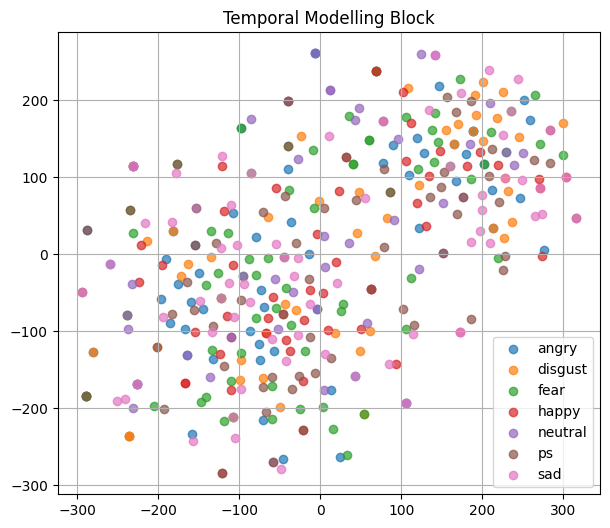

In [ ]:
class_names = dataset.label_encoder.classes_

plot_tsne(
    temporal_feats,
    labels_all,
    "Temporal Modelling Block",
    class_names
)

